
Задание 3

1) Изучить на скрытые темы "Преступление и наказание"

2) Реализовать тематическое моделирование через кластеризацию и BERTopic(считается как одно)

3) Сравнить эффективность использования евклидова расстояния и 2 других типов расстояния в кластеризации

4) Визуализировать кластера по выделенным топикам

5) Выложить на github

# Импорты и инсталлы

In [15]:
! pip install gensim
! pip install bertopic
! pip install umap-learn
! pip install jieba


# Часть 0(предобработочка)

Попробуем обработать данные(каким бы потрясающим не был способ, данные нада почистить. там еще и ValueError: Transform unavailable when model was fit with only a single data sample.... Кто б знал, как эту красоту решать, будем думать), но сначала их прочитаем(оглавление и все, что не связано с текстом произведения я удалил вручную)

In [16]:
with open('Crime And Punishment.txt', 'r') as f:
    text_data = f.read().replace('I', '').replace('V', '')
text_data

'\n\nЧасть первая\n\n\n\n\n\n\n\n\n\nВ начале июля, в чрезвычайно жаркое время, под вечер один молодой человек вышел из своей каморки, которую нанимал от жильцов в С-м переулке, на улицу и медленно, как бы в нерешимости, отправился к К-ну мосту.\n\nОн благополучно избегнул встречи с своею хозяйкой на лестнице. Каморка его приходилась под самою кровлей высокого пятиэтажного дома и походила более на шкаф, чем на квартиру. Квартирная же хозяйка его, у которой он нанимал эту каморку с обедом и прислугой, помещалась одною лестницей ниже, в отдельной квартире, и каждый раз, при выходе на улицу, ему непременно надо было проходить мимо хозяйкиной кухни, почти всегда настежь отворенной на лестницу. И каждый раз молодой человек, проходя мимо, чувствовал какое-то болезненное и трусливое ощущение, которого стыдился и от которого морщился. Он был должен кругом хозяйке и боялся с нею встретиться.\n\nНе то чтоб он был так труслив и забит, совсем даже напротив; но с некоторого времени он был в раздраж

Давайте нарежем по предложениям(чтобы потом модельке было на чем учиться + предложение - отличный вариант для представления текста в виде набора смысловых единиц)

In [17]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /home/ivzarru/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
def split_into_sentences(text):
    sentences = nltk.sent_tokenize(text)
    return sentences

In [19]:
sentences_data = split_into_sentences(text_data)
sentences_data

['\n\nЧасть первая\n\n\n\n\n\n\n\n\n\nВ начале июля, в чрезвычайно жаркое время, под вечер один молодой человек вышел из своей каморки, которую нанимал от жильцов в С-м переулке, на улицу и медленно, как бы в нерешимости, отправился к К-ну мосту.',
 'Он благополучно избегнул встречи с своею хозяйкой на лестнице.',
 'Каморка его приходилась под самою кровлей высокого пятиэтажного дома и походила более на шкаф, чем на квартиру.',
 'Квартирная же хозяйка его, у которой он нанимал эту каморку с обедом и прислугой, помещалась одною лестницей ниже, в отдельной квартире, и каждый раз, при выходе на улицу, ему непременно надо было проходить мимо хозяйкиной кухни, почти всегда настежь отворенной на лестницу.',
 'И каждый раз молодой человек, проходя мимо, чувствовал какое-то болезненное и трусливое ощущение, которого стыдился и от которого морщился.',
 'Он был должен кругом хозяйке и боялся с нею встретиться.',
 'Не то чтоб он был так труслив и забит, совсем даже напротив; но с некоторого време

Сделаем немного красоты, обернем в датафрейм

In [20]:
import pandas as pd

In [21]:
data = pd.DataFrame({'sentence': sentences_data})
data

sentence
0      \n\nЧасть первая\n\n\n\n\n\n\n\n\n\nВ начале и...
1      Он благополучно избегнул встречи с своею хозяй...
2      Каморка его приходилась под самою кровлей высо...
3      Квартирная же хозяйка его, у которой он нанима...
4      И каждый раз молодой человек, проходя мимо, чу...
...                                                  ...
13293  Но она была до того счастлива, что почти испуг...
13294                         Семь лет, только семь лет!
13295  В начале своего счастия, в иные мгновения, они...
13296  Он даже и не знал того, что новая жизнь не дар...
13297  Это могло бы составить тему нового рассказа, –...

[13298 rows x 1 columns]

Давайте сделаем +- то же самое, что делали во втором задании(почистим текст от стоп слов, англ слов и прочей гадости)

In [22]:
import pymorphy2
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from pymystem3 import Mystem



In [23]:
def pos(word, morph=pymorphy2.MorphAnalyzer()):
    return morph.parse(word)[0].tag.POS

def stop_words_cleaning(dataset):
    morph = pymorphy2.MorphAnalyzer(lang='ru')
    functors_pos = {'PREP', 'CONJ', 'PRCL', 'INTJ', 'NPRO'}
    nltk.download("stopwords")
    stop_words = stopwords.words("russian")
    mystem = Mystem() 
    dataset['sentence'] =  dataset['sentence'].apply(lambda x: ' '.join(mystem.lemmatize(x)))
    dataset['sentence'] = dataset['sentence'].apply(lambda x: word_tokenize(x))
    dataset['sentence'] = dataset['sentence'].apply(lambda x: [i for i in x if pos(i, morph) not in functors_pos])
    dataset['sentence'] = dataset['sentence'].apply(lambda x:[word for word in x if word not in stop_words and len(word) >1 and not re.search('[a-zA-Z]', word)])
    dataset.dropna(inplace=True)
    
    dataset['sentence'] = dataset['sentence'].apply(lambda x: ' '.join(x))

    return dataset

In [24]:
data = stop_words_cleaning(data)
data

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ivzarru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


sentence
0      часть первый начало июль чрезвычайно жаркий вр...
1      благополучно избегать встреча свой хозяйка лес...
2      каморка приходиться кровля высокий пятиэтажный...
3      квартирный хозяйка который нанимать каморка об...
4      каждый молодой человек проходить чувствовать к...
...                                                  ...
13293                 счастливый испугаться свой счастие
13294                                  семь год семь год
13295  начало свой счастие иной мгновение оба готовый...
13296  знать новый жизнь даром доставаться дорого куп...
13297  мочь составлять тема новый рассказ теперешний ...

[13298 rows x 1 columns]

И чуть почистим от всякой другой гадости

In [25]:
import string

In [26]:
def preprocess_text(text):
    pattern_punct = r'[^\w\s]'
    text = re.sub(pattern_punct, '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    pattern_digits = r'[+-]?\d+(\.\d+)?'
    text = re.sub(pattern_digits, '', text)
    pattern_tok = r'\b\w*tokenoid\w*\b'
    text = re.sub(pattern_tok, '', text)
    return text


In [27]:
data['sentence'] = data['sentence'].apply(lambda x:preprocess_text(''.join(x)))
data

sentence
0      часть первый начало июль чрезвычайно жаркий вр...
1      благополучно избегать встреча свой хозяйка лес...
2      каморка приходиться кровля высокий пятиэтажный...
3      квартирный хозяйка который нанимать каморка об...
4      каждый молодой человек проходить чувствовать к...
...                                                  ...
13293                 счастливый испугаться свой счастие
13294                                  семь год семь год
13295  начало свой счастие иной мгновение оба готовый...
13296  знать новый жизнь даром доставаться дорого куп...
13297  мочь составлять тема новый рассказ теперешний ...

[13298 rows x 1 columns]

# Часть 1(что я здесь забыл?) 



Вкусно...

Поработаем с берттопиком. Начнем знакомство с эмбеддингов и токенайзера
Для этого возьмем SBERT(https://huggingface.co/ai-forever/sbert_large_nlu_ru)

In [28]:
from transformers import AutoTokenizer, AutoModel
import torch
from bertopic import BERTopic


Инициализируем

In [29]:
emb_model = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru")
#encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=24, return_tensors='pt') 
#how 2 use

В качестве уменьшения размерности возьмем UMAP(напотестить, если будет гадость - поменяем)

In [30]:
from umap import UMAP



In [31]:
umap_model = UMAP(n_neighbors=10, n_components=4, metric='cosine')

В качестве алгоритма кластеризации используем HDBSCAN. Инициализируем 3 разных модельки(с разными расстояниями: евклидово, манхеттенское и косинусное)

In [32]:
from hdbscan import HDBSCAN


In [33]:
hdbscan_euclidean = HDBSCAN(metric='euclidean', min_cluster_size=15)
hdbscan_manhattan = HDBSCAN(metric='manhattan', min_cluster_size=15)
hdbscan_chebyshev = HDBSCAN(metric='chebyshev', min_cluster_size=15)



Я просто нагуглил эту штуку и мне она показалась очень забавной. Встречайте: жиба

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
import jieba

In [35]:
def tokenize_zh(text):
    words = jieba.lcut(text)
    return words

vectorizer = CountVectorizer(tokenizer=tokenize_zh, stop_words='russian')

Теперь tf-idf, но немного необычный. c-TF-IDF welcome

In [36]:
from bertopic.vectorizers import ClassTfidfTransformer


In [37]:
ctfidf_model = ClassTfidfTransformer()

Ну и давайте сделаем какую нибудь репрезентацию из относительно базовых штук

# Часть 2 (Собираем демонов, узнаем что по топикам)

In [38]:
topic_model= BERTopic(
        embedding_model=emb_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_euclidean,
        ctfidf_model=ctfidf_model,
        
)
topics, probs = topic_model.fit_transform(data['sentence'])


Получим уверенность модели во всем этом

In [39]:
probs

array([1.        , 0.85622529, 0.33325906, ..., 0.        , 1.        ,
       0.        ])

In [40]:
topics

[79,
 2,
 5,
 -1,
 1,
 10,
 -1,
 -1,
 -1,
 -1,
 10,
 4,
 -1,
 10,
 -1,
 -1,
 -1,
 -1,
 -1,
 8,
 -1,
 -1,
 80,
 -1,
 6,
 4,
 23,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 11,
 -1,
 4,
 8,
 7,
 28,
 1,
 80,
 -1,
 5,
 -1,
 64,
 5,
 -1,
 -1,
 -1,
 5,
 -1,
 -1,
 5,
 -1,
 -1,
 -1,
 -1,
 1,
 6,
 -1,
 19,
 -1,
 43,
 -1,
 1,
 -1,
 64,
 5,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 6,
 -1,
 -1,
 4,
 -1,
 2,
 -1,
 20,
 -1,
 20,
 -1,
 -1,
 9,
 7,
 -1,
 8,
 -1,
 22,
 -1,
 2,
 20,
 -1,
 70,
 7,
 -1,
 10,
 -1,
 33,
 -1,
 -1,
 -1,
 71,
 14,
 -1,
 13,
 -1,
 1,
 5,
 -1,
 -1,
 -1,
 18,
 -1,
 73,
 0,
 97,
 -1,
 -1,
 -1,
 -1,
 1,
 25,
 -1,
 -1,
 56,
 1,
 1,
 1,
 -1,
 2,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 8,
 -1,
 7,
 24,
 -1,
 -1,
 -1,
 21,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 7,
 -1,
 8,
 18,
 4,
 -1,
 -1,
 80,
 7,
 33,
 1,
 8,
 -1,
 -1,
 -1,
 -1,
 24,
 -1,
 -1,
 -1,
 -1,
 4,
 4,
 -1,
 -1,
 -1,
 -1,
 -1,
 7,
 -1,
 -1,
 -1,
 -1,
 6,
 98,
 1,
 -1,
 -1,
 12,
 -1,
 51,
 -1,
 -1,
 -1,
 8,
 6,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 31

Получим какие-нибудь интересные топики, чтобы понять, насколько модель хорошо это все делает

In [41]:
topic_model.get_topics()

{-1: [('весь', 0.007153682258366902),
  ('мочь', 0.006705765878846895),
  ('становиться', 0.006689245170941343),
  ('рука', 0.006593579427157959),
  ('раскольников', 0.00650344167713585),
  ('говорить', 0.006455857612119386),
  ('сказать', 0.006452156825777787),
  ('свой', 0.006183280448910185),
  ('соня', 0.005817779884458204),
  ('голова', 0.0055665343623309375)],
 0: [('', 1e-05),
  ('', 1e-05),
  ('', 1e-05),
  ('', 1e-05),
  ('', 1e-05),
  ('', 1e-05),
  ('', 1e-05),
  ('', 1e-05),
  ('', 1e-05),
  ('', 1e-05)],
 1: [('прощать', 0.03144160088170658),
  ('обращаться', 0.023990532259401627),
  ('сообщать', 0.017921023189272797),
  ('ощущение', 0.017153193246837718),
  ('отвращение', 0.014330220816099568),
  ('вещь', 0.012747454691827566),
  ('ощущать', 0.012308218067747246),
  ('защищать', 0.011999569422207446),
  ('общий', 0.01122232556979647),
  ('мещанин', 0.01122232556979647)],
 2: [('брат', 0.05156005306577806),
  ('больной', 0.03449795603376788),
  ('беспокоиться', 0.034093733

Визуализируем несколько из них в качестве облака слов

In [42]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

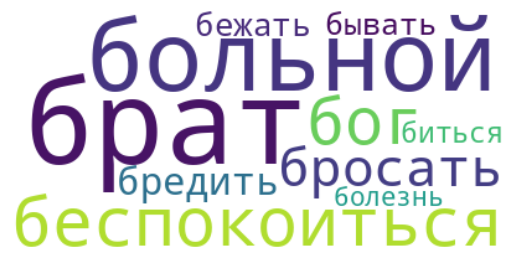

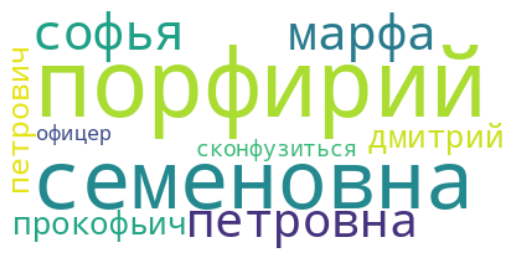

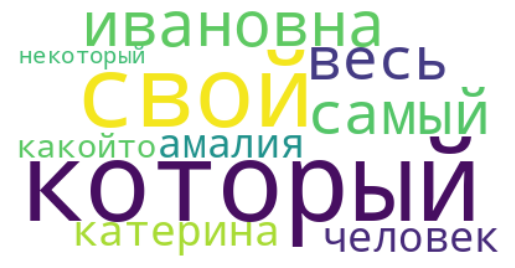

In [43]:


def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=2)
create_wordcloud(topic_model, topic=3)
create_wordcloud(topic_model, topic=4)

ы)

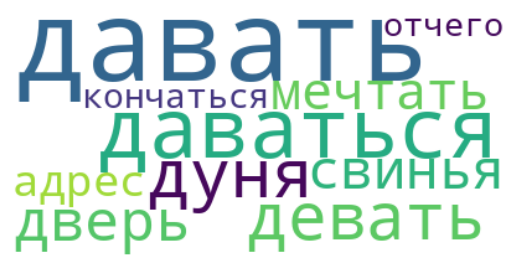

In [44]:
create_wordcloud(topic_model, topic=71)

ХМХМ.... Ну, смысл в этом есть

Давайте теперь обучим еще 2 модельки и посмотрим, что там у них(те же параметры, различие только в метриках расстояния для HDBSCAN'а), выполним те же действия, а в третей части порисуем немножечько(опустим только пробс и топикс, тк .get_topics() полно реализует функционал всего этого)
Начнем с косинусного расстояния

In [45]:
topic_model2= BERTopic(
        embedding_model=emb_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_manhattan,
        ctfidf_model=ctfidf_model,
        
)
topics2, probs2 = topic_model2.fit_transform(data['sentence'])

In [46]:
topic_model2.get_topics()

{-1: [('весь', 0.007112689599532275),
  ('сказать', 0.006760989105024587),
  ('мочь', 0.006483072500751892),
  ('становиться', 0.006473577678002591),
  ('раскольников', 0.006175556584746318),
  ('соня', 0.0061243050656542685),
  ('рука', 0.006115608328363861),
  ('свой', 0.006060852000182804),
  ('знать', 0.006060021229905615),
  ('говорить', 0.005904109330241416)],
 0: [('', 1e-05),
  ('', 1e-05),
  ('', 1e-05),
  ('', 1e-05),
  ('', 1e-05),
  ('', 1e-05),
  ('', 1e-05),
  ('', 1e-05),
  ('', 1e-05),
  ('', 1e-05)],
 1: [('порфирий', 0.07158923433328865),
  ('семеновна', 0.05132436484166393),
  ('софья', 0.051135233704569474),
  ('марфа', 0.047048742613438624),
  ('петровна', 0.04495830066570466),
  ('прокофьич', 0.021775457061241666),
  ('петрович', 0.021502496184551304),
  ('дмитрий', 0.021111964947891283),
  ('сконфузиться', 0.014245184596764656),
  ('офицер', 0.013235690834491462)],
 2: [('который', 0.011473248015513325),
  ('ивановна', 0.00954096734923956),
  ('свой', 0.009343809

Заметим, что классов меньше
Давайте повыводим какие нибудь вордклауды и поглядим, что там как там

Сразу можно сказать, что они заполненней

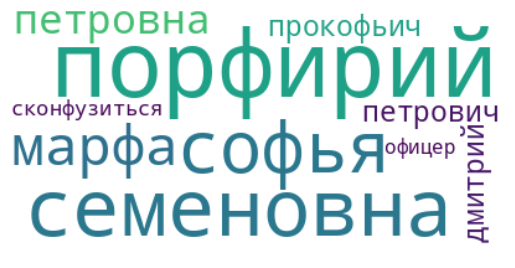

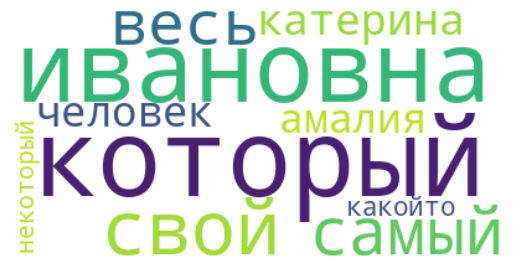

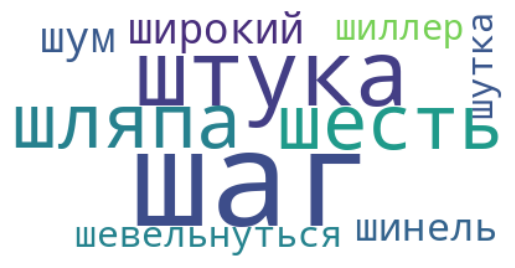

In [47]:
create_wordcloud(topic_model2, topic=1)
create_wordcloud(topic_model2, topic=2)
create_wordcloud(topic_model2, topic=4)

Тут тоже в 1м вордклауде фигурирует персонаж и глаголы, описывающие его в книге. Забавно

Для третей модельки используем расстояние чебышева, тк оно считается 3м основным помимо L1 и L2

In [48]:
topic_model3= BERTopic(
        embedding_model=emb_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_chebyshev,
        ctfidf_model=ctfidf_model,
        
)
topics3, probs3 = topic_model3.fit_transform(data['sentence'])

In [49]:
topic_model3.get_topics()

{-1: [('весь', 0.007290502501402953),
  ('мочь', 0.007083551532599907),
  ('рука', 0.006601733759387831),
  ('свой', 0.0064623590077752605),
  ('сказать', 0.00637258369259326),
  ('раскольников', 0.0061672965525162915),
  ('становиться', 0.006152238521563979),
  ('знать', 0.006052994072972531),
  ('говорить', 0.005899384069841756),
  ('соня', 0.005882480285736576)],
 0: [('', 1e-05),
  ('', 1e-05),
  ('', 1e-05),
  ('', 1e-05),
  ('', 1e-05),
  ('', 1e-05),
  ('', 1e-05),
  ('', 1e-05),
  ('', 1e-05),
  ('', 1e-05)],
 1: [('прощать', 0.03341914934130037),
  ('обращаться', 0.026289664961857605),
  ('ощущение', 0.019157760007486674),
  ('сообщать', 0.019016734951149982),
  ('отвращение', 0.015191691566515375),
  ('мещанин', 0.01512705465284044),
  ('защищать', 0.013850969531067648),
  ('ощущать', 0.013018762621307835),
  ('смущаться', 0.011450372832967638),
  ('вещь', 0.01131483827792796)],
 2: [('порфирий', 0.07308523772930334),
  ('семеновна', 0.05326688262551969),
  ('софья', 0.053095

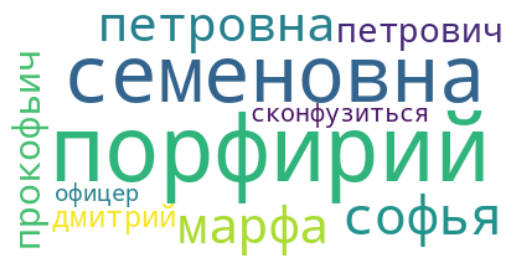

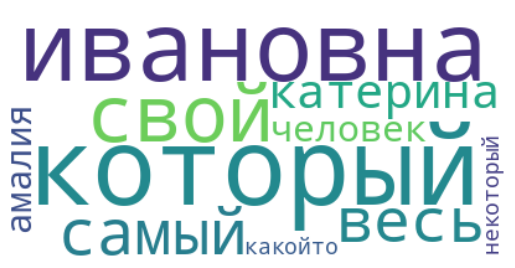

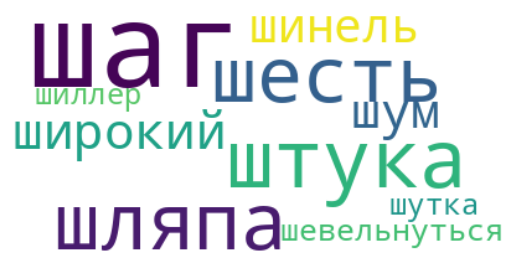

In [50]:
create_wordcloud(topic_model2, topic=1)
create_wordcloud(topic_model2, topic=2)
create_wordcloud(topic_model2, topic=4)

Давайте попробуем посчитать когерентность при помощи модуля gensim

(Когерентность - целостность и связность текста в темах)

In [51]:
from bertopic import BERTopic
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

In [56]:
def calculate_coherence_score(data, topic_model, coherence='c_v'):
    topic_words = []
    for topic in set(topics):
        try:
            if topic != -1:
                words = topic_model.get_topic(topic)[:5]
                topic_words.append([word for word, _ in words])
        except Exception:
            pass

    # Подготовка данных для расчета когерентности
    dictionary = Dictionary(topic_words)
    corpus = [dictionary.doc2bow(text) for text in topic_words]

    # Расчет когерентности
    coherence_model = CoherenceModel(topics=topic_words, texts=topic_words, dictionary=dictionary, coherence=coherence)
    coherence_score = coherence_model.get_coherence()

    return coherence_score

In [57]:
print(calculate_coherence_score(data['sentence'], topic_model))


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

0.998316832242971


In [58]:
print(calculate_coherence_score(data['sentence'], topic_model2))


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

0.997809403693264


In [59]:
print(calculate_coherence_score(data['sentence'], topic_model3))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

0.9981687441793099


Заметим, что все работает +- нормально(по крайней мере скоры близятся к единичке), но выдвинем гипотезу по моделькам, ранжируем по этой метрике расстояния от лучшего к худшему

1)Чебышева(третья модель)
2)Евклидово(первая модель)
3)Манхеттенское(вторая модель)

# Часть 3(что такое хорошо, а что такое плохо?)

Давайте порисуем

для начала визуализируем все топики, посмотрим как у нас все кластеризировалось

In [60]:
topic_model.visualize_documents(data['sentence'])


In [61]:
topic_model2.visualize_documents(data['sentence'])


In [62]:
topic_model3.visualize_documents(data['sentence'])


Окей, моделька работает хорошо, все кластеризует, давайте сделаем какие нибудь выводы по графикам:
1 ) Заметим, что все модельки справились +- одинаково, где-то больше классов, где-то меньше. Очень хорошо, что они не пересекаются
2) Некоторые персонажи соотнесены с глаголами, которые их описывают. Так, например, получился тема Разумихин_смех_раздаваться(а если вспомнить произведение, разумихин был человеком, который стремился всем помочь и почти все время находился в воодушевлении и позитивном состоянии) или же дуня_двинуться_дрыхнуть, что подчеркивает ее как робкого персонажа, с которым обращались не так, как надо было(опять же, подтверждается прочтением произведения)
3)заметим, что из-за разных расстояний количество тем разнится, но также нужно сказать, что оно никак не может интерпретироваться как оценка качества модели
4)Очень много тем, охарактериззованных глаголами. При этом по смыслу они совпадают. Но больше всего в этом плане отличилась модель с расстоянием Чернышевского
5)в класс 0 были отнесены те слова, которые не могут определиться к теме однозначно. Очень интересно было там заметить Раскольникова - показатель того, что он встречается почти везде как Главный герой и не может быть определен к чему-либо

Продолжим анализ и посмотрим на другие графики

In [65]:
topic_model.visualize_heatmap()


In [67]:
topic_model2.visualize_heatmap()


In [68]:
topic_model3.visualize_heatmap()

Заметим, что различий мало, но они есть. В третьем случаи топики чуть более зависимы друг от друга, в первом картинка в целом светлее, а во втором выделяется четкий квадрат зависимых топиков в левом верхнем углу. Забавно, что это может быть отличительной чертой манхеттенского расстояния, которое является суммой модулей разности

Рисуем дальше

In [70]:
topic_model.visualize_barchart()


In [71]:
topic_model2.visualize_barchart()


In [72]:
topic_model3.visualize_barchart()


Топ 7 тем каждой модели. Заметим, что есть очень странные темы, которые не сильно относятся к тексту, но также есть топик 2.3(второй в третей модели),1.2, 3.1  с персонажами, также ткждая модель выбрала разные глаголы для топ топиков(5.2, 7.3, 1.1) Все они характеризуют околократкий сюжет произведения(по крайней мере их можно так интерпретировать)
Заметим, что также иногда модельки заносит и они соотносят слова начинающиеся одинаково как слова одной темы

Поглядим на TF-IDF каждого топика